In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, RidgeCV, Ridge, Lasso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import patsy
import warnings
from sklearn.base import BaseEstimator, clone
import statsmodels.api as sm
warnings.simplefilter('ignore')
np.random.seed(1234)

In [2]:
# simple scalar regression "population" dgp
n = 10000
W = np.random.uniform(0, 1, size=(n, 1))
y = np.exp(2 * W[:, 0])
grid = np.linspace(0, 1, 1000).reshape(-1, 1)

In [3]:
# Let's fit BLPs with polynomial features
lr_poly = lambda p: make_pipeline(PolynomialFeatures(degree=p, include_bias=False),
                                  LinearRegression())
pred1 = lr_poly(3).fit(W, y).predict(grid)

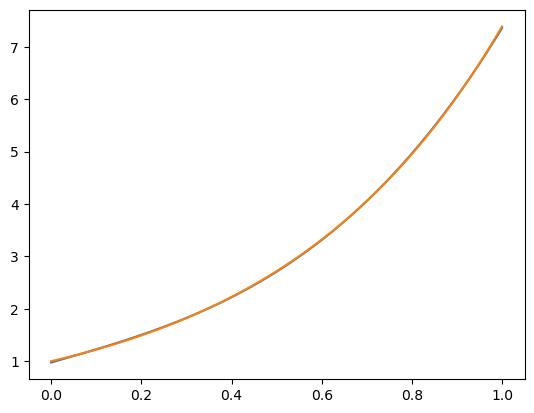

In [4]:
# even 3rd degree polynomial is good enough
plt.plot(grid, pred1)
plt.plot(grid, np.exp(2 * grid))
plt.show()

In [5]:
# Now let's go to finite sample and noisy data
n = 500
W = np.random.uniform(0, 1, size=(n, 1))
y = np.exp(2 * W[:, 0]) + np.random.normal(0, 5, size=n)
grid = np.linspace(0, 1, 1000).reshape(-1, 1)

In [6]:
# Let's fit a 10 degree polynomial
lr_poly = lambda p: make_pipeline(PolynomialFeatures(degree=p, include_bias=False),
                                  LinearRegression())
pred1 = lr_poly(10).fit(W, y).predict(grid)

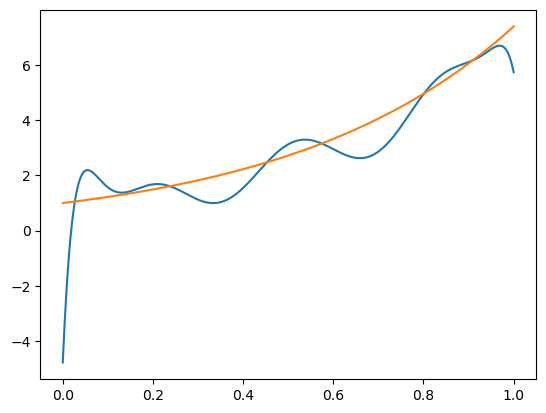

In [7]:
# It is very noisy!
plt.plot(grid, pred1)
plt.plot(grid, np.exp(2 * grid))
plt.show()

In [8]:
# What if we use Lasso with cross-validated penalty
lr_poly = lambda p: make_pipeline(PolynomialFeatures(degree=p, include_bias=False),
                                  StandardScaler(),
                                  LassoCV(cv=5))
pred1 = lr_poly(10).fit(W, y).predict(grid)

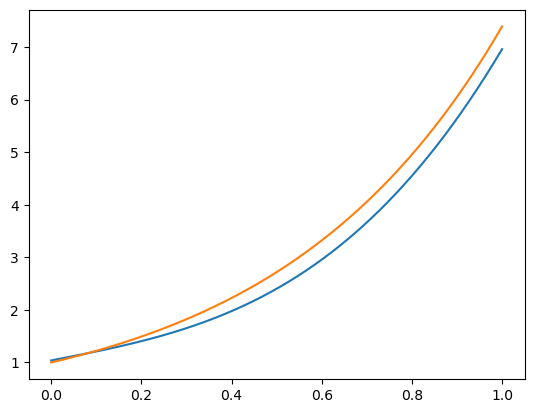

In [9]:
# Much more stable
plt.plot(grid, pred1)
plt.plot(grid, np.exp(2 * grid))
plt.show()

# A more complex DGP

In [10]:
# Let's go to a real high-dimensional dgp
def gen_data(n, p, *, sparse=True):
    if sparse:
        beta = (1 / np.arange(1, p)) ** 2
    else:
        beta = ((np.random.normal(0, 1, p - 1)) * 0.2)
    true_fn = lambda x: np.exp(2 * x[:, 0]) + (x[:, 1:] @ beta)
    X = np.random.uniform(-.5, .5, size=(n, p))
    gX = true_fn(X) 
    y = gX + np.random.normal(0, 1, n)
    Xtest = np.random.uniform(-.5, .5, size=(n, p))
    gXtest = true_fn(Xtest)
    ytest = gXtest + np.random.normal(0, 1, n)
    Xpop = np.random.uniform(-.5, .5, size=(10000, p)) # almost population limit
    gXpop = true_fn(Xpop)
    ypop = gXpop + np.random.normal(0, 1, 10000) # almost population limit
    return X, y, gX, Xtest, ytest, gXtest, Xpop, ypop, gXpop

In [11]:
np.random.seed(123)
X, y, gX, Xtest, ytest, gXtest, Xpop, ypop, gXpop = gen_data(100, 400)

In [12]:
r2_score(ypop, gXpop) # The best r-squared we can hope for

0.33641445133307446

In [13]:
lr = LinearRegression().fit(X, y) # what does OLS do

In [14]:
r2_score(ypop, lr.predict(Xpop)) # negative out-of-sample R^2! Worse than a constant prediction

-0.10973075049794656

In [15]:
lcv = make_pipeline(StandardScaler(), LassoCV()) # let's use LassoCV
lcv.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()), ('lassocv', LassoCV())])

In [16]:
r2_score(ypop, lcv.predict(Xpop)) # a positive R-square close to the best

0.23844851136266676

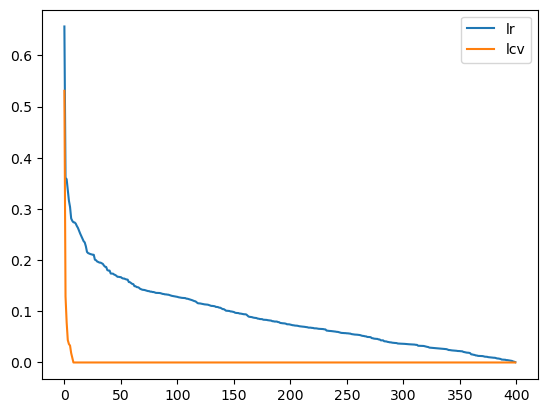

In [17]:
# Let's look at the distribution of coefficients of the differnt models
lrcoefs = np.abs(lr.coef_)
plt.plot(lrcoefs[np.argsort(lrcoefs)[::-1]], label='lr')
lcvcoefs = np.abs(lcv[-1].coef_)
plt.plot(lcvcoefs[np.argsort(lcvcoefs)[::-1]], label='lcv')
plt.legend()
plt.show()

In [18]:
# Let's verify the inutition behind the lasso and the marginal predictive abilit
ulcv = LassoCV().fit(X, y)

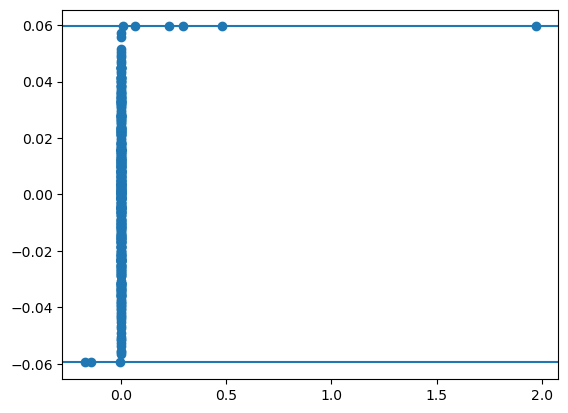

In [19]:
score = X.T @ (y - ulcv.predict(X)) / X.shape[0]
plt.scatter(ulcv.coef_, score)
plt.axhline(ulcv.alpha_)
plt.axhline(-ulcv.alpha_)
plt.show()

In [20]:
# What if we chose the penalty based on theory, not cross-validation
# We wrap the package so that it has the familiar sklearn API
import hdmpy

class RLasso(BaseEstimator):
    
    def __init__(self, *, post=False):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    @property
    def coef_(self):
        return self.rlasso_.est['beta'].values.flatten()

    def predict(self, X):
        return X @ self.coef_ + self.rlasso_.est['intercept'].values

In [21]:
rlasso = RLasso().fit(X, y)

In [22]:
r2_score(ypop, rlasso.predict(Xpop)) # pretty good!

0.21842174729732677

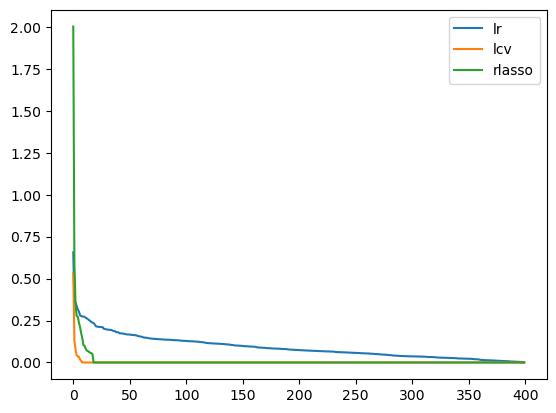

In [23]:
lrcoefs = np.abs(lr.coef_)
plt.plot(lrcoefs[np.argsort(lrcoefs)[::-1]], label='lr')
lcvcoefs = np.abs(lcv[-1].coef_)
plt.plot(lcvcoefs[np.argsort(lcvcoefs)[::-1]], label='lcv')
rlassocoefs = np.abs(rlasso.coef_)
plt.plot(rlassocoefs[np.argsort(rlassocoefs)[::-1]], label='rlasso')
plt.legend()
plt.show()

In [24]:
# Let's try post lasso OLS
class PostLassoOLS(BaseEstimator):

    def fit(self, X, y):
        # We train LassoCV
        lasso = LassoCV().fit(X, y)
        # We find the non-zero coefficients
        self.feats_ = np.abs(lasso.coef_) > 1e-6
        # We train OLS on them
        self.lr_ = LinearRegression().fit(X[:, self.feats_], y)
        return self

    def predict(self, X):
        return self.lr_.predict(X[:, self.feats_])

    @property
    def coef_(self):
        return self.lr_.coef_

In [25]:
plasso = PostLassoOLS().fit(X, y)

In [26]:
r2_score(ypop, plasso.predict(Xpop))

-0.050489240477440855

Very Poor! Post (LassoCV) OLS is not the same as CV-ing the whole Post-Lasso-OLS process. Post (LassoCV) OLS is wrong! Let's CV the whole process!

In [27]:
class PostLassoOLS(BaseEstimator):
    
    def __init__(self, *, alpha=1):
        self.alpha = alpha

    def fit(self, X, y):
        lasso = Lasso(self.alpha).fit(X, y)
        self.feats_ = np.abs(lasso.coef_) > 1e-6
        self.lr_ = LinearRegression().fit(X[:, self.feats_], y)
        return self

    def predict(self, X):
        return self.lr_.predict(X[:, self.feats_])

    @property
    def coef_(self):
        return self.lr_.coef_

In [28]:
lcv = GridSearchCV(PostLassoOLS(), {'alpha': np.logspace(-4, 4, 10)},
                   scoring='r2')
lcv = make_pipeline(StandardScaler(), lcv)
lcv.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(estimator=PostLassoOLS(),
                              param_grid={'alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])},
                              scoring='r2'))])

In [29]:
r2_score(ypop, lcv.predict(Xpop)) # much better

0.166286782831505

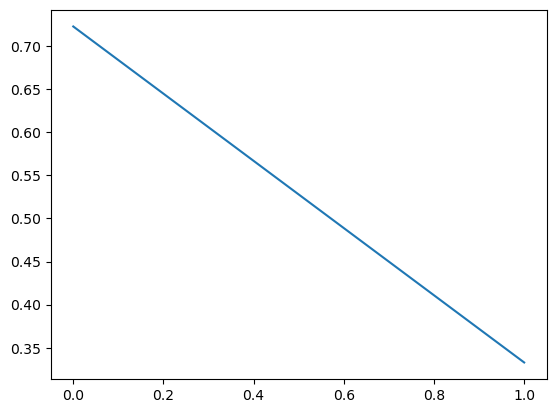

In [30]:
plt.plot(np.abs(lcv[-1].best_estimator_.coef_)[np.argsort(np.abs(lcv[-1].best_estimator_.coef_))[::-1]])
plt.show()

In [31]:
# The theoretical driven approach also supports post lasso OLS
# choses a penalty appropriate for the post-lasso-ols model
lcv = make_pipeline(StandardScaler(), RLasso(post=True))

In [32]:
lcv.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rlasso', RLasso(post=True))])

In [33]:
r2_score(ypop, lcv.predict(Xpop))

0.23040048026438686

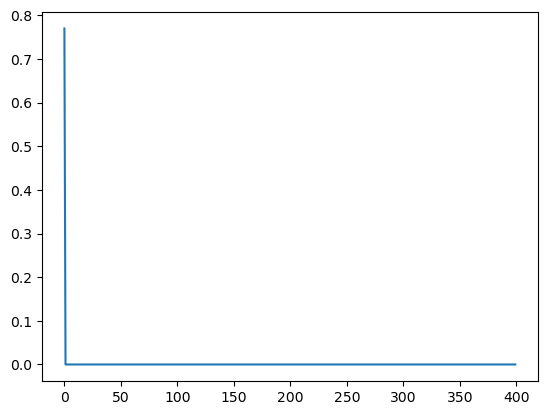

In [34]:
plt.plot(np.abs(lcv[-1].coef_)[np.argsort(np.abs(lcv[-1].coef_))[::-1]])
plt.show()

Let's try other penalty approaches

In [35]:
ridge = make_pipeline(StandardScaler(), RidgeCV()).fit(X, y)

In [36]:
r2_score(ypop, ridge.predict(Xpop))

-0.08645559239393896

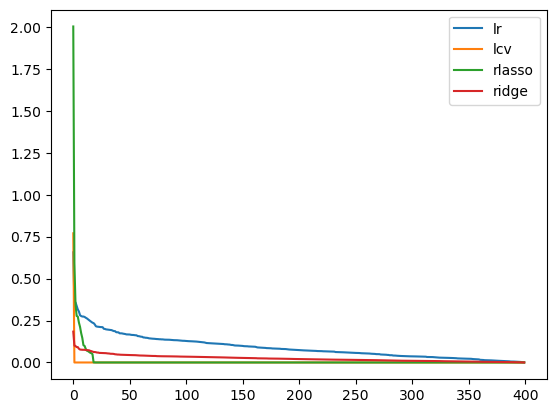

In [37]:
lrcoefs = np.abs(lr.coef_)
plt.plot(lrcoefs[np.argsort(lrcoefs)[::-1]], label='lr')
lcvcoefs = np.abs(lcv[-1].coef_)
plt.plot(lcvcoefs[np.argsort(lcvcoefs)[::-1]], label='lcv')
rlassocoefs = np.abs(rlasso.coef_)
plt.plot(rlassocoefs[np.argsort(rlassocoefs)[::-1]], label='rlasso')
ridgecoefs = np.abs(ridge[-1].coef_)
plt.plot(ridgecoefs[np.argsort(ridgecoefs)[::-1]], label='ridge')
plt.legend()
plt.show()

In [38]:
enet = make_pipeline(StandardScaler(), ElasticNetCV()).fit(X, y)

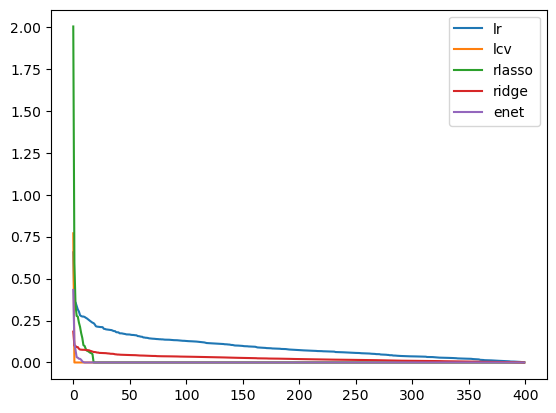

In [39]:
lrcoefs = np.abs(lr.coef_)
plt.plot(lrcoefs[np.argsort(lrcoefs)[::-1]], label='lr')
lcvcoefs = np.abs(lcv[-1].coef_)
plt.plot(lcvcoefs[np.argsort(lcvcoefs)[::-1]], label='lcv')
rlassocoefs = np.abs(rlasso.coef_)
plt.plot(rlassocoefs[np.argsort(rlassocoefs)[::-1]], label='rlasso')
ridgecoefs = np.abs(ridge[-1].coef_)
plt.plot(ridgecoefs[np.argsort(ridgecoefs)[::-1]], label='ridge')
enetcoefs = np.abs(enet[-1].coef_)
plt.plot(enetcoefs[np.argsort(enetcoefs)[::-1]], label='enet')
plt.legend()
plt.show()

## Wage Prediction

Let's try all these approaches for wage prediction

In [40]:
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/wage2015_subsample_inference.csv"
data = pd.read_csv(file)

In [41]:
data.describe()

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
count,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000
mean,23.410410,2.970787,0.444466,0.023301,0.243883,0.278058,0.317670,0.137087,0.259612,0.296505,0.216117,0.227767,13.760583,3.018925,8.235867,25.118038,5310.737476,11.670874,6629.154951,13.316893
std,21.003016,0.570385,0.496955,0.150872,0.429465,0.448086,0.465616,0.343973,0.438464,0.456761,0.411635,0.419432,10.609465,4.000904,14.488962,53.530225,11874.356080,6.966684,5333.443992,5.701019
min,3.021978,1.105912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,370.000000,2.000000
25%,13.461538,2.599837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.250000,0.125000,0.062500,1740.000000,5.000000,4880.000000,9.000000
50%,19.230769,2.956512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,1.000000,1.000000,4040.000000,13.000000,7370.000000,14.000000
75%,27.777778,3.324236,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,21.000000,4.410000,9.261000,19.448100,5610.000000,17.000000,8190.000000,18.000000
max,528.845673,6.270697,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,47.000000,22.090000,103.823000,487.968100,100000.000000,22.000000,100000.000000,22.000000


In [42]:
y = np.log(data['wage']).values
Z = data.drop(['wage', 'lwage'], axis=1)
Z.columns

Index(['sex', 'shs', 'hsg', 'scl', 'clg', 'ad', 'mw', 'so', 'we', 'ne', 'exp1',
       'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind', 'ind2'],
      dtype='object')

In [43]:
Zbase = patsy.dmatrix('0 + sex + exp1 + shs + hsg+ scl + clg + mw + so + we + C(occ2) + C(ind2)',
                      Z, return_type='dataframe').values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(Zbase, y, test_size=0.25, random_state=123)

In [45]:
lr_base = LinearRegression().fit(X_train, y_train)

In [46]:
print(f'{r2_score(y_test, lr_base.predict(X_test)):.4f}')

0.2853


In [47]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)

In [48]:
np.mean(cross_val_score(LinearRegression(), Zbase, y, scoring='r2', cv=cv))

0.29533051768666346

In [49]:
Zflex = patsy.dmatrix('0 + sex + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+C(occ2)+C(ind2)+mw+so+we)',
                      Z, return_type='dataframe').values

In [50]:
np.mean(cross_val_score(LinearRegression(), Zflex, y, scoring='r2', cv=cv, n_jobs=-1))

-4310928603349694.5

OLS is very unstable!! Result depends on exactly how you implemented ols for ill-posed covariance matrices!

In [51]:
class MyOLS(BaseEstimator):

    def fit(self, X, y):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        self.ols_ = sm.OLS(y, X).fit()
        return self

    def predict(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        return self.ols_.predict(X)
    
    @property
    def coef_(self):
        return self.ols_.params[1:]

In [52]:
np.mean(cross_val_score(MyOLS(), Zflex, y, scoring='r2', cv=cv, n_jobs=-1))

0.25217224997945015

In [53]:
np.mean(cross_val_score(LassoCV(cv=cv), Zflex, y, scoring='r2', cv=cv, n_jobs=-1))

0.2796914535001022

In [54]:
Zflex = StandardScaler().fit_transform(Zflex)

In [55]:
np.mean(cross_val_score(LassoCV(cv=cv), Zflex, y, scoring='r2', cv=cv, n_jobs=-1))

0.29591518129317207

In [56]:
np.mean(cross_val_score(RidgeCV(cv=cv), Zflex, y, scoring='r2', cv=cv, n_jobs=-1))

0.285263522612187

In [57]:
np.mean(cross_val_score(ElasticNetCV(cv=cv), Zflex, y, scoring='r2', cv=cv, n_jobs=-1))

0.29603340816822693

In [58]:
lcv = LassoCV(cv=cv).fit(Zflex, y)
ridge = RidgeCV(cv=cv).fit(Zflex, y)
enet = ElasticNetCV(cv=cv).fit(Zflex, y)
lr = MyOLS().fit(Zflex, y)

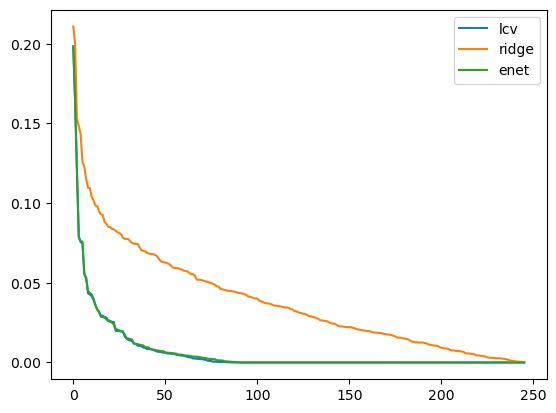

In [59]:
plt.plot(np.abs(lcv.coef_)[np.argsort(np.abs(lcv.coef_))[::-1]], label='lcv')
plt.plot(np.abs(ridge.coef_)[np.argsort(np.abs(ridge.coef_))[::-1]], label='ridge')
plt.plot(np.abs(enet.coef_)[np.argsort(np.abs(enet.coef_))[::-1]], label='enet')
# plt.plot(np.abs(lr.coef_)[np.argsort(np.abs(lr.coef_))[::-1]])
plt.legend()
plt.show()

In the end vanilla OLS on the low dimensional feature map is pretty good. It's not always the case that going to very high dimensional features and using penalization will improve your R-square. Never forget poor OLS on a small set of hand-picked features. After all OLS is also a machine learning algorithm :)